In [2]:
!pip uninstall xgboost
!pip install xgboost-0.81-py2.py3-none-manylinux1_x86_64.whl

Uninstalling xgboost-0.90:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/xgboost-0.90.dist-info/*
    /usr/local/lib/python3.6/dist-packages/xgboost/*
    /usr/local/xgboost/libxgboost.so
Proceed (y/n)? y
  Successfully uninstalled xgboost-0.90
Processing ./xgboost-0.81-py2.py3-none-manylinux1_x86_64.whl


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [38]:
import numpy as np
import pandas as pd

data = pd.read_csv('drive/My Drive/train.csv')
(nb_sample,nb_feature) = data.shape
print(data.shape)
data.head(5)

(58881, 129)


,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,InsuredInfo_8,InsuredInfo_9,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,...,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,1,A8,26,0.230769,2,3,1,0.492537,0.563636,0.225941,0.510720,0.0244,9,1,0.0,2,0.05,2,2,3,3,1,1,Female,NaN,Muslim,2,1,1,3,NaN,3,2,3,3,0.681159,NaN,0.492958,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
1,1,D2,26,1.000000,3,3,1,0.671642,0.781818,0.326360,0.453033,0.5000,3,1,0.5,2,1.00,1,2,8,3,1,1,Male,NaN,NaN,2,1,3,1,0.006667,1,3,2,2,NaN,0.490196,NaN,0.589286,4.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
2,1,D2,26,0.230769,2,3,1,0.626866,0.745455,0.393305,0.598310,0.0400,9,1,0.0,2,0.60,1,2,4,3,1,1,Male,Caucasian,Jewish,1,3,3,1,0.000833,1,1,2,3,NaN,0.558824,NaN,0.598214,3.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,1,D4,26,0.230769,2,3,1,0.268657,0.690909,0.246862,0.410638,0.0300,9,1,0.0,2,0.00,1,2,6,2,1,1,Female,NaN,NaN,2,1,1,3,NaN,3,2,3,2,0.536232,NaN,0.478873,NaN,12.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
4,1,E1,10,0.230769,2,3,1,0.641791,0.581818,0.466527,1.000000,0.0280,9,1,0.0,3,1.00,1,2,8,3,1,1,Female,NaN,NaN,2,1,3,1,0.000039,1,3,2,2,NaN,0.647059,NaN,0.160714,1.0,...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,2


In [39]:
nb_delete_1415 = 0
for i in range(nb_sample):
    if i < (nb_sample-nb_delete_1415):
        nb_missing = data.iloc[i,:].isnull().sum()
        if nb_missing >= 13:
            data.drop(index=[i],inplace=True)
            nb_delete_1415+=1
    else:
        break
print('totally delete: ',nb_delete_1415, 'samples')
data.reset_index(drop = True,inplace = True)

totally delete:  29 samples


In [40]:
import gc
del data['Medical_History_10'],data['Medical_History_32'],data['Medical_History_24'],data['InsuredInfo_8'],data['Medical_History_15'],data['InsuredInfo_9'],data['Family_Hist_5']
data = data.join(pd.get_dummies(data['InsuredInfo_7']))
del data['InsuredInfo_7']
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(data['Product_Info_2'])
data['Product_Info_2'] = le.transform(data['Product_Info_2'])
missing_features = pd.DataFrame(data.dtypes,columns=['dtypes'])
missing_features = missing_features.reset_index()
missing_features['Name'] = missing_features['index']
del missing_features['index']
missing_features.reset_index(drop=True,inplace=True)
missing_features = missing_features[data.isnull().sum().values!=0]
gc.collect()

452

#### Comparison between fillin-missing data operations

##### mean

In [8]:
print('using mean of the features to fill the missing values:')
data_preprocessed = data.copy()
data_preprocessed.fillna(data_preprocessed.mean()[missing_features.Name],inplace=True)

tabel_var = data_preprocessed[data_preprocessed.columns].var().sort_values(ascending=True)
tabel_var = tabel_var.head(5)
tabel_var.reset_index()
for column in tabel_var.index.tolist():
    del data_preprocessed[column]
print('low variance features are deleted.')

X_temp = data_preprocessed
X_temp = X_temp.corr()
tabel_corr = abs(X_temp[['Response']]).sort_values(by=['Response'],ascending=True)
tabel_corr = tabel_corr.head(5)
tabel_corr.reset_index()
for column in tabel_corr.index.tolist():
    del data_preprocessed[column]
del X_temp
print('low correlation features are deleted.')

y_data = data_preprocessed['Response']
del data_preprocessed['Response']
gc.collect()

using mean of the features to fill the missing values:
low variance features are deleted.
low correlation features are deleted.


55

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(data_preprocessed, y_data, test_size=0.15, stratify=y_data,random_state=0)
print(X_train.shape)
print(X_validation.shape)

(50024, 112)
(8828, 112)


In [10]:
# here we can also use grid search to find the best hyperparameters to tune the model
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(max_depth=10,n_estimators=2000)
clf_rf.fit(X_train,y_train)
print('validation set presicion:',clf_rf.score(X_validation,y_validation))
print('training set precision:',clf_rf.score(X_train,y_train))

validation set presicion: 0.5131400090620752
training set precision: 0.5669278746201823


In [11]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=7)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_validation)
print('validation set presicion:',accuracy_score(y_validation, y_pred))
y_pred = clf.predict(X_train)
print('training set precision:',accuracy_score(y_train, y_pred))

validation set presicion: 0.3192115994562755
training set precision: 0.48288821365744444


In [12]:
X_train.reset_index(drop=True,inplace=True)
X_validation.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_validation.reset_index(drop=True,inplace=True)

from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost as xgb
from tqdm import tqdm
folds = 4
seed = 10
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
models = []
for tr_idx, val_idx in tqdm(kf.split(X_train,y_train)):
    def fit_classifier(tr_idx, val_idx):
        tr_x, tr_y = X_train.iloc[tr_idx], y_train[tr_idx]
        vl_x, vl_y = X_train.iloc[val_idx], y_train[val_idx]
        print({'train size':len(tr_x), 'eval size':len(vl_x)})

        tr_data = xgb.DMatrix(tr_x, label=tr_y)
        vl_data = xgb.DMatrix(vl_x, label=vl_y)  
        clf = xgb.XGBClassifier(n_estimators=2000,
                                learning_rate=0.01,
                                feature_fraction=0.9,
                                subsample=0.25,  # batches of 25% of the data
                                subsample_freq=1,
                                lambda_l2=0.2,
                                num_leaves=30,
                                tree_method = 'gpu_hist',
                                metric='mse')
        clf.fit(tr_x, tr_y,
                eval_set=[(tr_x, tr_y),(vl_x, vl_y)],
                early_stopping_rounds=150,
                verbose=250)
        return clf
    clf = fit_classifier(tr_idx, val_idx)
    models.append(clf)

0it [00:00, ?it/s]

{'train size': 37518, 'eval size': 12506}
[0]	validation_0-merror:0.498827	validation_1-merror:0.497281
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.480276	validation_1-merror:0.483048
[500]	validation_0-merror:0.469028	validation_1-merror:0.475372
[750]	validation_0-merror:0.458766	validation_1-merror:0.469375
[1000]	validation_0-merror:0.451836	validation_1-merror:0.465137
[1250]	validation_0-merror:0.444986	validation_1-merror:0.461938
[1500]	validation_0-merror:0.439736	validation_1-merror:0.459539
[1750]	validation_0-merror:0.434938	validation_1-merror:0.456981
Stopping. Best iteration:
[1833]	validation_0-merror:0.433285	validation_1-merror:0.456261



1it [00:56, 56.61s/it]

{'train size': 37518, 'eval size': 12506}
[0]	validation_0-merror:0.511808	validation_1-merror:0.514153
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.479876	validation_1-merror:0.475692
[500]	validation_0-merror:0.469561	validation_1-merror:0.471214
[750]	validation_0-merror:0.4593	validation_1-merror:0.465936
[1000]	validation_0-merror:0.451703	validation_1-merror:0.462498
[1250]	validation_0-merror:0.44536	validation_1-merror:0.45762
[1500]	validation_0-merror:0.438989	validation_1-merror:0.456821
[1750]	validation_0-merror:0.434192	validation_1-merror:0.455142
Stopping. Best iteration:
[1787]	validation_0-merror:0.433312	validation_1-merror:0.454102



2it [01:44, 54.14s/it]

{'train size': 37518, 'eval size': 12506}
[0]	validation_0-merror:0.508503	validation_1-merror:0.513434
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.477238	validation_1-merror:0.487286
[500]	validation_0-merror:0.467509	validation_1-merror:0.481929
[750]	validation_0-merror:0.458687	validation_1-merror:0.475052
[1000]	validation_0-merror:0.449198	validation_1-merror:0.470174
[1250]	validation_0-merror:0.444373	validation_1-merror:0.467775
[1500]	validation_0-merror:0.438456	validation_1-merror:0.464417
[1750]	validation_0-merror:0.434032	validation_1-merror:0.462418
[1999]	validation_0-merror:0.429181	validation_1-merror:0.460259


3it [02:35, 52.98s/it]

{'train size': 37518, 'eval size': 12506}
[0]	validation_0-merror:0.508902	validation_1-merror:0.510395
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.47929	validation_1-merror:0.486087
[500]	validation_0-merror:0.469775	validation_1-merror:0.476651
[750]	validation_0-merror:0.459673	validation_1-merror:0.465776
[1000]	validation_0-merror:0.452823	validation_1-merror:0.461618
[1250]	validation_0-merror:0.445813	validation_1-merror:0.45754
[1500]	validation_0-merror:0.439602	validation_1-merror:0.455701
[1750]	validation_0-merror:0.435924	validation_1-merror:0.454582
[1999]	validation_0-merror:0.4315	validation_1-merror:0.454022


4it [03:25, 52.31s/it]


In [15]:
res_preds = []
for i in range(4):
  res_preds.append(models[i].predict(X_validation))
  print('xgboost'+str(i),accuracy_score(y_validation,res_preds[i]))
res = []
for i in range(len(y_validation)):
  res_temp = []
  for j in range(4): 
    res_temp.append(res_preds[j][i])
  res.append(np.argmax(np.bincount(res_temp)))
from sklearn.metrics import accuracy_score
print('test set precision 4 models hard voting:',accuracy_score(y_validation, res))
res_preds = []
for i in range(4):
  res_preds.append(models[i].predict(X_validation))
res_preds.append(clf_rf.predict(X_validation))
res = []
for i in range(len(y_validation)):
  res_temp = []
  for j in range(5): 
    res_temp.append(res_preds[j][i])
  res.append(np.argmax(np.bincount(res_temp)))
from sklearn.metrics import accuracy_score
print('test set precision 5 models hard voting:',accuracy_score(y_validation, res))

xgboost0 0.544404168554599
xgboost1 0.5425917535115542
xgboost2 0.542931581332125
xgboost3 0.5424784775713638
test set precision 4 models hard voting: 0.5437245129134571
test set precision 5 models hard voting: 0.542931581332125


##### In using mean, the accuracy result on validation set is:
    rf model: 0.5131400090620752
    knn: 0.3192115994562755
    xgboost0 0.544404168554599
    xgboost1 0.5425917535115542
    xgboost2 0.542931581332125
    xgboost3 0.5424784775713638
    4 xgboost hard voting: 0.5437245129134571
    4 xgboost+rf hard voting: 0.542931581332125

##### median

In [16]:
print('using median of the features to fill the missing values:')
data_preprocessed = data.copy()
data_preprocessed.fillna(data_preprocessed.median()[missing_features.Name],inplace=True)

tabel_var = data_preprocessed[data_preprocessed.columns].var().sort_values(ascending=True)
tabel_var = tabel_var.head(5)
tabel_var.reset_index()
for column in tabel_var.index.tolist():
    del data_preprocessed[column]
print('low variance features are deleted.')

X_temp = data_preprocessed
X_temp = X_temp.corr()
tabel_corr = abs(X_temp[['Response']]).sort_values(by=['Response'],ascending=True)
tabel_corr = tabel_corr.head(5)
tabel_corr.reset_index()
for column in tabel_corr.index.tolist():
    del data_preprocessed[column]
del X_temp
print('low correlation features are deleted.')

y_data = data_preprocessed['Response']
del data_preprocessed['Response']
gc.collect()

using median of the features to fill the missing values:
low variance features are deleted.
low correlation features are deleted.


161

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(data_preprocessed, y_data, test_size=0.15, stratify=y_data,random_state=0)
print(X_train.shape)
print(X_validation.shape)

(50024, 112)
(8828, 112)


In [18]:
# here we can also use grid search to find the best hyperparameters to tune the model
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(max_depth=10,n_estimators=2000)
clf_rf.fit(X_train,y_train)
print('validation set presicion:',clf_rf.score(X_validation,y_validation))
print('training set precision:',clf_rf.score(X_train,y_train))

validation set presicion: 0.5131400090620752
training set precision: 0.5676275387813849


In [19]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=7)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_validation)
print('validation set presicion:',accuracy_score(y_validation, y_pred))
y_pred = clf.predict(X_train)
print('training set precision:',accuracy_score(y_train, y_pred))

validation set presicion: 0.3194381513366561
training set precision: 0.48326803134495444


In [20]:
X_train.reset_index(drop=True,inplace=True)
X_validation.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_validation.reset_index(drop=True,inplace=True)

from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost as xgb
from tqdm import tqdm
folds = 4
seed = 10
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
models = []
for tr_idx, val_idx in tqdm(kf.split(X_train,y_train)):
    def fit_classifier(tr_idx, val_idx):
        tr_x, tr_y = X_train.iloc[tr_idx], y_train[tr_idx]
        vl_x, vl_y = X_train.iloc[val_idx], y_train[val_idx]
        print({'train size':len(tr_x), 'eval size':len(vl_x)})

        tr_data = xgb.DMatrix(tr_x, label=tr_y)
        vl_data = xgb.DMatrix(vl_x, label=vl_y)  
        clf = xgb.XGBClassifier(n_estimators=2000,
                                learning_rate=0.01,
                                feature_fraction=0.9,
                                subsample=0.25,  # batches of 25% of the data
                                subsample_freq=1,
                                lambda_l2=0.2,
                                num_leaves=30,
                                tree_method = 'gpu_hist',
                                metric='mse')
        clf.fit(tr_x, tr_y,
                eval_set=[(tr_x, tr_y),(vl_x, vl_y)],
                early_stopping_rounds=150,
                verbose=250)
        return clf
    clf = fit_classifier(tr_idx, val_idx)
    models.append(clf)

0it [00:00, ?it/s]

{'train size': 37518, 'eval size': 12506}
[0]	validation_0-merror:0.498827	validation_1-merror:0.497281
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.480463	validation_1-merror:0.484328
[500]	validation_0-merror:0.468788	validation_1-merror:0.476331
[750]	validation_0-merror:0.459593	validation_1-merror:0.469775
[1000]	validation_0-merror:0.452503	validation_1-merror:0.464337
[1250]	validation_0-merror:0.446026	validation_1-merror:0.461219
[1500]	validation_0-merror:0.440082	validation_1-merror:0.45906
[1750]	validation_0-merror:0.434858	validation_1-merror:0.457061
Stopping. Best iteration:
[1812]	validation_0-merror:0.433445	validation_1-merror:0.456261



1it [00:48, 48.56s/it]

{'train size': 37518, 'eval size': 12506}
[0]	validation_0-merror:0.511808	validation_1-merror:0.514153
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.480036	validation_1-merror:0.475612
[500]	validation_0-merror:0.470228	validation_1-merror:0.471454
[750]	validation_0-merror:0.460206	validation_1-merror:0.466256
[1000]	validation_0-merror:0.45165	validation_1-merror:0.462418
[1250]	validation_0-merror:0.44544	validation_1-merror:0.45762
[1500]	validation_0-merror:0.439096	validation_1-merror:0.456981
[1750]	validation_0-merror:0.434192	validation_1-merror:0.454102
Stopping. Best iteration:
[1742]	validation_0-merror:0.434405	validation_1-merror:0.453782



2it [01:35, 48.13s/it]

{'train size': 37518, 'eval size': 12506}
[0]	validation_0-merror:0.508476	validation_1-merror:0.513434
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.477024	validation_1-merror:0.487766
[500]	validation_0-merror:0.467775	validation_1-merror:0.482249
[750]	validation_0-merror:0.45858	validation_1-merror:0.474972
[1000]	validation_0-merror:0.449304	validation_1-merror:0.472013
[1250]	validation_0-merror:0.444453	validation_1-merror:0.468415
[1500]	validation_0-merror:0.438989	validation_1-merror:0.463777
[1750]	validation_0-merror:0.434245	validation_1-merror:0.462498
[1999]	validation_0-merror:0.428781	validation_1-merror:0.460819


3it [02:25, 48.54s/it]

{'train size': 37518, 'eval size': 12506}
[0]	validation_0-merror:0.508902	validation_1-merror:0.510395
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.478997	validation_1-merror:0.486247
[500]	validation_0-merror:0.469934	validation_1-merror:0.476571
[750]	validation_0-merror:0.460366	validation_1-merror:0.466096
[1000]	validation_0-merror:0.453142	validation_1-merror:0.461778
[1250]	validation_0-merror:0.445946	validation_1-merror:0.4593
[1500]	validation_0-merror:0.439975	validation_1-merror:0.456661
Stopping. Best iteration:
[1573]	validation_0-merror:0.438323	validation_1-merror:0.455142



4it [03:08, 46.85s/it]


In [21]:
res_preds = []
for i in range(4):
  res_preds.append(models[i].predict(X_validation))
  print('xgboost'+str(i),accuracy_score(y_validation,res_preds[i]))
res = []
for i in range(len(y_validation)):
  res_temp = []
  for j in range(4): 
    res_temp.append(res_preds[j][i])
  res.append(np.argmax(np.bincount(res_temp)))
from sklearn.metrics import accuracy_score
print('test set precision 4 models hard voting:',accuracy_score(y_validation, res))
res_preds = []
for i in range(4):
  res_preds.append(models[i].predict(X_validation))
res_preds.append(clf_rf.predict(X_validation))
res = []
for i in range(len(y_validation)):
  res_temp = []
  for j in range(5): 
    res_temp.append(res_preds[j][i])
  res.append(np.argmax(np.bincount(res_temp)))
from sklearn.metrics import accuracy_score
print('test set precision 5 models hard voting:',accuracy_score(y_validation, res))

xgboost0 0.5445174444947893
xgboost1 0.5425917535115542
xgboost2 0.5434979610330766
xgboost3 0.540666062528319
test set precision 4 models hard voting: 0.5423652016311735
test set precision 5 models hard voting: 0.5434979610330766


##### In using median, the accuracy result on validation set is:
    rf model: 0.5131400090620752
    knn: 0.3194381513366561
    xgboost0 0.5445174444947893
    xgboost1 0.5425917535115542
    xgboost2 0.5434979610330766
    xgboost3 0.540666062528319
    4 xgboost hard voting: 0.5423652016311735
    4 xgboost+rf hard voting: 0.5434979610330766

    model     mean      median
    rf       0.513     0.513
    knn       0.319     0.319
    xgboost1    0.544     0.544
    xgboost2    0.543     0.543
    xgboost3    0.543     0.543
    xgboost4    0.542     0.541
    4xgb_voting   0.544     0.542
    4xgb+rf_voting  0.543     0.543

#### So 'mean' is better

#### After choosing important features, we make the some processing on outliers

In [41]:
data.fillna(data.mean()[missing_features.Name],inplace=True)

tabel_var = data[data.columns].var().sort_values(ascending=True)
tabel_var = tabel_var.head(5)
tabel_var.reset_index()
for column in tabel_var.index.tolist():
    del data[column]
print('low variance features are deleted.')

X_temp = data
X_temp = X_temp.corr()
tabel_corr = abs(X_temp[['Response']]).sort_values(by=['Response'],ascending=True)
tabel_corr = tabel_corr.head(5)
tabel_corr.reset_index()
for column in tabel_corr.index.tolist():
    del data[column]
del X_temp
print('low correlation features are deleted.')

y_data = data['Response']
del data['Response']
gc.collect()

important_features = ['BMI', 'Product_Info_4', 'Medical_History_4', 'Ins_Age', 'Wt', 'Medical_History_23', 'Medical_Keyword_3', 'Medical_Keyword_15', 'Product_Info_2', 'Employment_Info_1', 'Family_Hist_3', 'Medical_History_1', 'Family_Hist_4', 'Employment_Info_6', 'Medical_History_2', 'Family_Hist_2', 'Employment_Info_2', 'Medical_History_30', 'Female', 'InsuredInfo_3', 'Medical_History_40', 'Medical_History_13', 'Medical_History_39', 'Medical_History_28', 'Insurance_History_2', 'Family_Hist_1', 'InsuredInfo_5', 'InsuredInfo_6', 'InsuredInfo_2', 'Medical_History_18', 'InsuredInfo_1', 'Product_Info_3', 'Insurance_History_8', 'Medical_History_33', 'Medical_Keyword_23']
data = data[important_features]
data['Response'] = y_data
data.drop(data[data['Medical_History_18']==3].index,axis=0,inplace=True)
data.drop(data[data['Medical_History_28']==3].index,axis=0,inplace=True)
data.drop(data[data['Medical_History_39']==2].index,axis=0,inplace=True)
data.drop(data[data['Medical_History_13']==2].index,axis=0,inplace=True)
data.drop(data[data['Medical_History_40']==2].index,axis=0,inplace=True)
data.drop(data[data['Medical_History_30']==1].index,axis=0,inplace=True)
data.drop(data[data['InsuredInfo_3']==9].index,axis=0,inplace=True)
data.drop(data[data['Medical_History_1']>=150].index,axis=0,inplace=True)
data.drop(data[data['Insurance_History_2']==2].index,axis=0,inplace=True)
data.reset_index(drop=True,inplace=True)
y_data = data['Response']
del data['Response']
gc.collect()

low variance features are deleted.
low correlation features are deleted.


0

#### Comparison among Class-balanced, Over-sampling, Under-sampling, Normal datasets

##### Under-sampling

In [0]:
data_preprocessed = data.copy()

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(data_preprocessed, y_data, test_size=0.15, stratify=y_data,random_state=0)
print(X_train.shape)
print(X_validation.shape)
from imblearn.under_sampling import NearMiss
nm = NearMiss(version=2)
X_train, y_train = nm.fit_resample(X_train, y_train)
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
for i in range(len(X_train.columns)):
  X_train.rename(columns={i:important_features[i]},inplace=True)
y_train.rename(columns={0:"Response"},inplace=True)

X_train['Response'] = y_train
y_train = X_train['Response']
del X_train['Response']
gc.collect()

# here we can also use grid search to find the best hyperparameters to tune the model
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(max_depth=10,n_estimators=800)
clf_rf.fit(X_train,y_train)
print('validation set presicion:',clf_rf.score(X_validation,y_validation))
print('training set precision:',clf_rf.score(X_train,y_train))

(49959, 35)
(8817, 35)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

validation set presicion: 0.18464330271067256
training set precision: 0.7255847953216374


In [44]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(data_preprocessed, y_data, test_size=0.15, stratify=y_data,random_state=0)
print(X_train.shape)
print(X_validation.shape)
from imblearn.under_sampling import NearMiss
nm = NearMiss(version=1)
X_train, y_train = nm.fit_resample(X_train, y_train)
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
for i in range(len(X_train.columns)):
  X_train.rename(columns={i:important_features[i]},inplace=True)
y_train.rename(columns={0:"Response"},inplace=True)

X_train['Response'] = y_train
y_train = X_train['Response']
del X_train['Response']
gc.collect()

# here we can also use grid search to find the best hyperparameters to tune the model
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(max_depth=10,n_estimators=800)
clf_rf.fit(X_train,y_train)
print('validation set presicion:',clf_rf.score(X_validation,y_validation))
print('training set precision:',clf_rf.score(X_train,y_train))

(49959, 35)
(8817, 35)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

validation set presicion: 0.24169218555064081
training set precision: 0.6641812865497077


In [50]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(data_preprocessed, y_data, test_size=0.15, stratify=y_data,random_state=0)
print(X_train.shape)
print(X_validation.shape)
from imblearn.under_sampling import RandomUnderSampler
nm = RandomUnderSampler(random_state=0)
X_train, y_train = nm.fit_resample(X_train, y_train)
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
for i in range(len(X_train.columns)):
  X_train.rename(columns={i:important_features[i]},inplace=True)
y_train.rename(columns={0:"Response"},inplace=True)

X_train['Response'] = y_train
y_train = X_train['Response']
del X_train['Response']
gc.collect()

# here we can also use grid search to find the best hyperparameters to tune the model
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(max_depth=10,n_estimators=400)
clf_rf.fit(X_train,y_train)
print('validation set presicion:',clf_rf.score(X_validation,y_validation))
print('training set precision:',clf_rf.score(X_train,y_train))

(49959, 35)
(8817, 35)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


validation set presicion: 0.42973800612453217
training set precision: 0.6703216374269005


In [52]:
X_train.reset_index(drop=True,inplace=True)
X_validation.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_validation.reset_index(drop=True,inplace=True)
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost as xgb
from tqdm import tqdm
folds = 4
seed = 0
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
models = []
for tr_idx, val_idx in tqdm(kf.split(X_train,y_train)):
    def fit_classifier(tr_idx, val_idx):
        tr_x, tr_y = X_train[list(X_train)].iloc[tr_idx], y_train[tr_idx]
        vl_x, vl_y = X_train[list(X_train)].iloc[val_idx], y_train[val_idx]
        print({'train size':len(tr_x), 'eval size':len(vl_x)})

        tr_data = xgb.DMatrix(tr_x, label=tr_y)
        vl_data = xgb.DMatrix(vl_x, label=vl_y)  
        clf = xgb.XGBClassifier(n_estimators=1000,
                                learning_rate=0.01,
                                feature_fraction=0.8,
                                max_depth = 10,
                                subsample=0.25,  
                                subsample_freq=1, 
                                lambda_l2=1.2,
                                num_leaves=30,
                                tree_method = 'gpu_hist',
                                metric='mse')
        clf.fit(tr_x, tr_y,
                eval_set=[(tr_x, tr_y),(vl_x, vl_y)],
                early_stopping_rounds=150,
                verbose=250)
        return clf
    clf = fit_classifier(tr_idx, val_idx)
    models.append(clf)

0it [00:00, ?it/s]

{'train size': 5130, 'eval size': 1710}
[0]	validation_0-merror:0.583431	validation_1-merror:0.661988
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.309357	validation_1-merror:0.559064
Stopping. Best iteration:
[250]	validation_0-merror:0.309357	validation_1-merror:0.559064



1it [00:30, 30.70s/it]

{'train size': 5130, 'eval size': 1710}
[0]	validation_0-merror:0.591423	validation_1-merror:0.670175
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
Stopping. Best iteration:
[77]	validation_0-merror:0.407212	validation_1-merror:0.570175



2it [00:47, 26.63s/it]

{'train size': 5130, 'eval size': 1710}
[0]	validation_0-merror:0.580702	validation_1-merror:0.655556
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
Stopping. Best iteration:
[71]	validation_0-merror:0.402534	validation_1-merror:0.564912



3it [01:04, 23.76s/it]

{'train size': 5130, 'eval size': 1710}
[0]	validation_0-merror:0.575049	validation_1-merror:0.669006
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.312086	validation_1-merror:0.575439
Stopping. Best iteration:
[126]	validation_0-merror:0.382456	validation_1-merror:0.566082



4it [01:25, 22.91s/it]


In [53]:
res_preds = []
for i in range(4):
  res_preds.append(models[i].predict(X_validation))
  print('xgboost'+str(i),accuracy_score(y_validation,res_preds[i]))
res = []
for i in range(len(y_validation)):
  res_temp = []
  for j in range(4): 
    res_temp.append(res_preds[j][i])
  res.append(np.argmax(np.bincount(res_temp)))
from sklearn.metrics import accuracy_score
print('test set precision 4 models hard voting:',accuracy_score(y_validation, res))
res_preds = []
for i in range(4):
  res_preds.append(models[i].predict(X_validation))
res_preds.append(clf_rf.predict(X_validation))
res = []
for i in range(len(y_validation)):
  res_temp = []
  for j in range(5): 
    res_temp.append(res_preds[j][i])
  res.append(np.argmax(np.bincount(res_temp)))
from sklearn.metrics import accuracy_score
print('test set precision 5 models hard voting:',accuracy_score(y_validation, res))

xgboost0 0.4411931495973687
xgboost1 0.4417602359079052
xgboost2 0.43574912101621865
xgboost3 0.44414199841215835
test set precision 4 models hard voting: 0.4384711353067937
test set precision 5 models hard voting: 0.44085289781104686


##### Over-sampling

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(data_preprocessed, y_data, test_size=0.15, stratify=y_data,random_state=0)
print(X_train.shape)
print(X_validation.shape)
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
for i in range(len(X_train.columns)):
  X_train.rename(columns={i:important_features[i]},inplace=True)
y_train.rename(columns={0:"Response"},inplace=True)

X_train['Response'] = y_train
y_train = X_train['Response']
del X_train['Response']
gc.collect()

# here we can also use grid search to find the best hyperparameters to tune the model
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(max_depth=10,n_estimators=800)
clf_rf.fit(X_train,y_train)
print('validation set presicion:',clf_rf.score(X_validation,y_validation))
print('training set precision:',clf_rf.score(X_train,y_train))

(49959, 35)
(8817, 35)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

validation set presicion: 0.48916865146875355
training set precision: 0.564131495486704


In [55]:
X_train.reset_index(drop=True,inplace=True)
X_validation.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_validation.reset_index(drop=True,inplace=True)
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost as xgb
from tqdm import tqdm
folds = 4
seed = 0
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
models = []
for tr_idx, val_idx in tqdm(kf.split(X_train,y_train)):
    def fit_classifier(tr_idx, val_idx):
        tr_x, tr_y = X_train[list(X_train)].iloc[tr_idx], y_train[tr_idx]
        vl_x, vl_y = X_train[list(X_train)].iloc[val_idx], y_train[val_idx]
        print({'train size':len(tr_x), 'eval size':len(vl_x)})

        tr_data = xgb.DMatrix(tr_x, label=tr_y)
        vl_data = xgb.DMatrix(vl_x, label=vl_y)  
        clf = xgb.XGBClassifier(n_estimators=1000,
                                learning_rate=0.01,
                                feature_fraction=0.8,
                                max_depth = 10,
                                subsample=0.25,  
                                subsample_freq=1, 
                                lambda_l2=1.2,
                                num_leaves=30,
                                tree_method = 'gpu_hist',
                                metric='mse')
        clf.fit(tr_x, tr_y,
                eval_set=[(tr_x, tr_y),(vl_x, vl_y)],
                early_stopping_rounds=150,
                verbose=250)
        return clf
    clf = fit_classifier(tr_idx, val_idx)
    models.append(clf)

0it [00:00, ?it/s]

{'train size': 98376, 'eval size': 32792}
[0]	validation_0-merror:0.469789	validation_1-merror:0.506435
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.322325	validation_1-merror:0.404123
[500]	validation_0-merror:0.267819	validation_1-merror:0.37253
[750]	validation_0-merror:0.222656	validation_1-merror:0.347768
[999]	validation_0-merror:0.181447	validation_1-merror:0.325567


1it [04:25, 265.01s/it]

{'train size': 98376, 'eval size': 32792}
[0]	validation_0-merror:0.470216	validation_1-merror:0.505611
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.322081	validation_1-merror:0.401866
[500]	validation_0-merror:0.268429	validation_1-merror:0.371828
[750]	validation_0-merror:0.221212	validation_1-merror:0.347646
[999]	validation_0-merror:0.179932	validation_1-merror:0.327122


2it [08:53, 266.19s/it]

{'train size': 98376, 'eval size': 32792}
[0]	validation_0-merror:0.475848	validation_1-merror:0.505154
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.324388	validation_1-merror:0.397018
[500]	validation_0-merror:0.269649	validation_1-merror:0.364266
[750]	validation_0-merror:0.222605	validation_1-merror:0.340449
[999]	validation_0-merror:0.181843	validation_1-merror:0.322945


3it [13:25, 267.91s/it]

{'train size': 98376, 'eval size': 32792}
[0]	validation_0-merror:0.471965	validation_1-merror:0.504025
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.323128	validation_1-merror:0.401744
[500]	validation_0-merror:0.268785	validation_1-merror:0.372316
[750]	validation_0-merror:0.221955	validation_1-merror:0.348652
[999]	validation_0-merror:0.180532	validation_1-merror:0.32761


4it [17:59, 269.57s/it]


In [56]:
res_preds = []
for i in range(4):
  res_preds.append(models[i].predict(X_validation))
  print('xgboost'+str(i),accuracy_score(y_validation,res_preds[i]))
res = []
for i in range(len(y_validation)):
  res_temp = []
  for j in range(4): 
    res_temp.append(res_preds[j][i])
  res.append(np.argmax(np.bincount(res_temp)))
from sklearn.metrics import accuracy_score
print('test set precision 4 models hard voting:',accuracy_score(y_validation, res))
res_preds = []
for i in range(4):
  res_preds.append(models[i].predict(X_validation))
res_preds.append(clf_rf.predict(X_validation))
res = []
for i in range(len(y_validation)):
  res_temp = []
  for j in range(5): 
    res_temp.append(res_preds[j][i])
  res.append(np.argmax(np.bincount(res_temp)))
from sklearn.metrics import accuracy_score
print('test set precision 5 models hard voting:',accuracy_score(y_validation, res))

xgboost0 0.544743109901327
xgboost1 0.5456504479981853
xgboost2 0.5461041170466145
xgboost3 0.5436089372802541
test set precision 4 models hard voting: 0.543949189066576
test set precision 5 models hard voting: 0.5453101962118635


##### Normal

In [89]:
from sklearn.model_selection import train_test_split
data_preprocessed = data.copy()
X_train, X_validation, y_train, y_validation = train_test_split(data_preprocessed, y_data, test_size=0.15, stratify=y_data,random_state=0)
print(X_train.shape)
print(X_validation.shape)
# here we can also use grid search to find the best hyperparameters to tune the model
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(max_depth=10,n_estimators=1500)
clf_rf.fit(X_train,y_train)
print('validation set presicion:',clf_rf.score(X_validation,y_validation))
print('training set precision:',clf_rf.score(X_train,y_train))

(49959, 35)
(8817, 35)
validation set presicion: 0.5353294771464217
training set precision: 0.5801557276967113


In [90]:
X_train.reset_index(drop=True,inplace=True)
X_validation.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_validation.reset_index(drop=True,inplace=True)
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost as xgb
from tqdm import tqdm
folds = 4
seed = 0
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
models = []
for tr_idx, val_idx in tqdm(kf.split(X_train,y_train)):
    def fit_classifier(tr_idx, val_idx):
        tr_x, tr_y = X_train[list(X_train)].iloc[tr_idx], y_train[tr_idx]
        vl_x, vl_y = X_train[list(X_train)].iloc[val_idx], y_train[val_idx]
        print({'train size':len(tr_x), 'eval size':len(vl_x)})

        tr_data = xgb.DMatrix(tr_x, label=tr_y)
        vl_data = xgb.DMatrix(vl_x, label=vl_y)  
        clf = xgb.XGBClassifier(n_estimators=1000,
                                learning_rate=0.01,
                                feature_fraction=0.8,
                                max_depth = 10,
                                subsample=0.25,  
                                subsample_freq=1, 
                                lambda_l2=1.2,
                                num_leaves=30,
                                tree_method = 'gpu_hist',
                                metric='mse')
        clf.fit(tr_x, tr_y,
                eval_set=[(tr_x, tr_y),(vl_x, vl_y)],
                early_stopping_rounds=150,
                verbose=250)
        return clf
    clf = fit_classifier(tr_idx, val_idx)
    models.append(clf)


0it [00:00, ?it/s]

{'train size': 37469, 'eval size': 12490}
[0]	validation_0-merror:0.472551	validation_1-merror:0.508967
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.362406	validation_1-merror:0.461169
[500]	validation_0-merror:0.317329	validation_1-merror:0.458527
Stopping. Best iteration:
[500]	validation_0-merror:0.317329	validation_1-merror:0.458527




1it [01:52, 112.65s/it]

{'train size': 37469, 'eval size': 12490}
[0]	validation_0-merror:0.469348	validation_1-merror:0.504884
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.360698	validation_1-merror:0.463971
[500]	validation_0-merror:0.317436	validation_1-merror:0.460689
Stopping. Best iteration:
[567]	validation_0-merror:0.305719	validation_1-merror:0.458527




2it [03:55, 115.64s/it]

{'train size': 37469, 'eval size': 12490}
[0]	validation_0-merror:0.472204	validation_1-merror:0.516573
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.364168	validation_1-merror:0.459808
[500]	validation_0-merror:0.319758	validation_1-merror:0.452362
[750]	validation_0-merror:0.273479	validation_1-merror:0.451881
Stopping. Best iteration:
[711]	validation_0-merror:0.280685	validation_1-merror:0.450841




3it [06:24, 125.64s/it]

{'train size': 37470, 'eval size': 12489}
[0]	validation_0-merror:0.472111	validation_1-merror:0.502202
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.365359	validation_1-merror:0.457843
[500]	validation_0-merror:0.319135	validation_1-merror:0.455761
[750]	validation_0-merror:0.27446	validation_1-merror:0.45416
Stopping. Best iteration:
[639]	validation_0-merror:0.293808	validation_1-merror:0.453359




4it [08:40, 128.94s/it]


In [91]:
from sklearn.metrics import accuracy_score

res_preds = []
for i in range(4):
  res_preds.append(models[i].predict(X_validation))
  print('xgboost'+str(i),accuracy_score(y_validation,res_preds[i]))
res = []
for i in range(len(y_validation)):
  res_temp = []
  for j in range(4): 
    res_temp.append(res_preds[j][i])
  res.append(np.argmax(np.bincount(res_temp)))
from sklearn.metrics import accuracy_score
print('test set precision 4 models hard voting:',accuracy_score(y_validation, res))
res_preds = []
for i in range(4):
  res_preds.append(models[i].predict(X_validation))
res_preds.append(clf_rf.predict(X_validation))
res = []
for i in range(len(y_validation)):
  res_temp = []
  for j in range(5): 
    res_temp.append(res_preds[j][i])
  res.append(np.argmax(np.bincount(res_temp)))
from sklearn.metrics import accuracy_score
print('test set precision 5 models hard voting:',accuracy_score(y_validation, res))

xgboost0 0.5542701599183396
xgboost1 0.553249404559374
xgboost2 0.5485992968129749
xgboost3 0.5525689009867302
test set precision 4 models hard voting: 0.5557445843257344
test set precision 5 models hard voting: 0.554043325394125


In [48]:
from sklearn.metrics import classification_report as cr
print(cr(y_validation,res))

              precision    recall  f1-score   support

           1       0.47      0.27      0.35       923
           2       0.48      0.25      0.33       972
           3       0.36      0.05      0.09       151
           4       0.38      0.13      0.19       213
           5       0.62      0.56      0.59       807
           6       0.43      0.56      0.49      1667
           7       0.47      0.37      0.41      1190
           8       0.66      0.88      0.76      2894

    accuracy                           0.56      8817
   macro avg       0.48      0.38      0.40      8817
weighted avg       0.54      0.56      0.53      8817



#### Modification on important features
    1. test on fewer important features like 20 feautres
    2. caculate the lowest correlation features and delete them

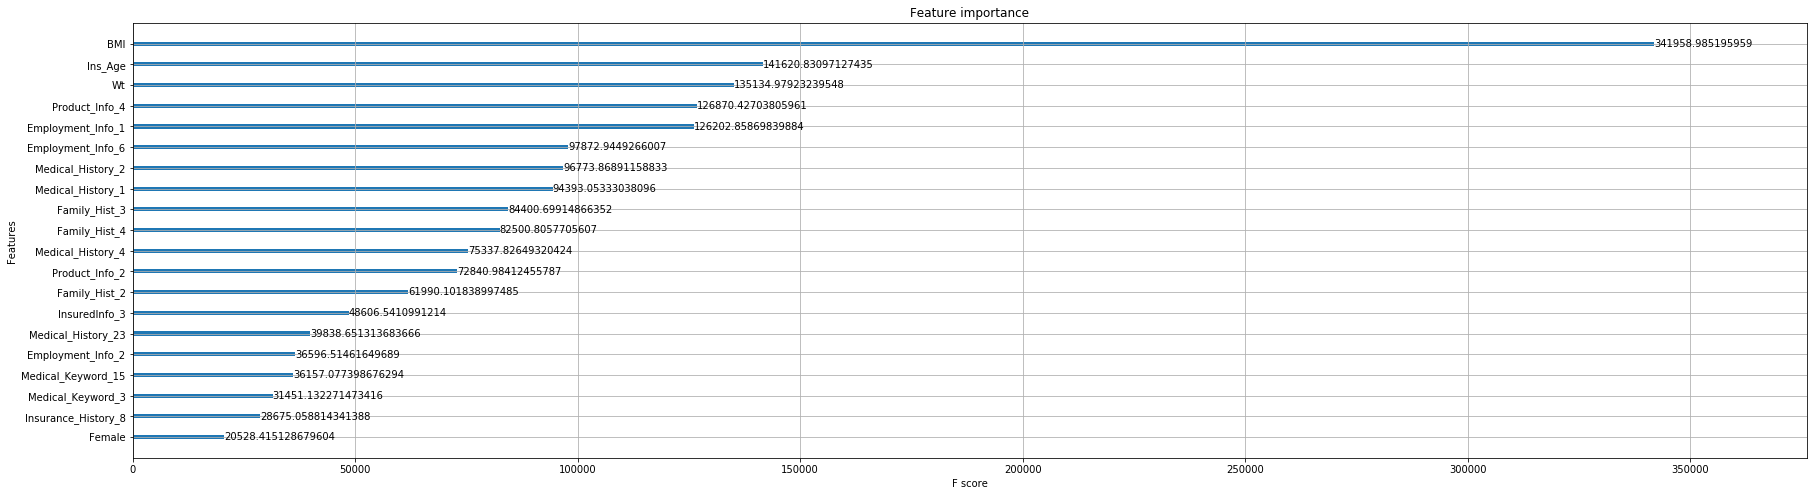

In [94]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (30, 8)
_ = xgb.plot_importance(models[0], importance_type='total_gain',max_num_features=20)

In [95]:
important_features = []
xgb_importance = models[0].get_booster().get_score(importance_type="total_gain")
xgb_importance = sorted(xgb_importance.items(),key=lambda item:item[-1],reverse=True)
for item in xgb_importance:
  important_features.append(item[0])
important_features

['BMI',
 'Ins_Age',
 'Wt',
 'Product_Info_4',
 'Employment_Info_1',
 'Employment_Info_6',
 'Medical_History_2',
 'Medical_History_1',
 'Family_Hist_3',
 'Family_Hist_4',
 'Medical_History_4',
 'Product_Info_2',
 'Family_Hist_2',
 'InsuredInfo_3',
 'Medical_History_23',
 'Employment_Info_2',
 'Medical_Keyword_15',
 'Medical_Keyword_3',
 'Insurance_History_8',
 'Female',
 'Family_Hist_1',
 'Medical_History_13',
 'Medical_History_30',
 'InsuredInfo_1',
 'Product_Info_3',
 'Medical_History_39',
 'Medical_History_33',
 'Medical_History_28',
 'Medical_History_40',
 'Medical_History_18',
 'Insurance_History_2',
 'InsuredInfo_6',
 'InsuredInfo_5',
 'InsuredInfo_2',
 'Medical_Keyword_23']

In [0]:
important_features = important_features[:15]
data_preprocessed = data_preprocessed[important_features]

In [97]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(data_preprocessed, y_data, test_size=0.15, stratify=y_data,random_state=0)
print(X_train.shape)
print(X_validation.shape)
# here we can also use grid search to find the best hyperparameters to tune the model
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(max_depth=10,n_estimators=1500)
clf_rf.fit(X_train,y_train)
print('validation set presicion:',clf_rf.score(X_validation,y_validation))
print('training set precision:',clf_rf.score(X_train,y_train))

(49959, 15)
(8817, 15)
validation set presicion: 0.5136667800839287
training set precision: 0.564062531275646


In [0]:
important_features = important_features[:10]
data_preprocessed = data_preprocessed[important_features]

In [99]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(data_preprocessed, y_data, test_size=0.15, stratify=y_data,random_state=0)
print(X_train.shape)
print(X_validation.shape)
# here we can also use grid search to find the best hyperparameters to tune the model
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(max_depth=10,n_estimators=1500)
clf_rf.fit(X_train,y_train)
print('validation set presicion:',clf_rf.score(X_validation,y_validation))
print('training set precision:',clf_rf.score(X_train,y_train))

(49959, 10)
(8817, 10)
validation set presicion: 0.47794034252013157


In [100]:
data_preprocessed = data.copy()
data_preprocessed['Response'] = y_data
tabel_var = data_preprocessed[data_preprocessed.columns].var().sort_values(ascending=True)
tabel_var = tabel_var.head(10)
tabel_var.reset_index()
for column in tabel_var.index.tolist():
    del data_preprocessed[column]
print('low variance features are deleted.')

X_temp = data_preprocessed
X_temp = X_temp.corr()
tabel_corr = abs(X_temp[['Response']]).sort_values(by=['Response'],ascending=True)
tabel_corr = tabel_corr.head(10)
tabel_corr.reset_index()
for column in tabel_corr.index.tolist():
    del data_preprocessed[column]
del X_temp
print('low correlation features are deleted.')

y_data = data_preprocessed['Response']
del data_preprocessed['Response']
gc.collect()


low variance features are deleted.
low correlation features are deleted.


16221

In [101]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(data_preprocessed, y_data, test_size=0.15, stratify=y_data,random_state=0)
print(X_train.shape)
print(X_validation.shape)
# here we can also use grid search to find the best hyperparameters to tune the model
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(max_depth=10,n_estimators=1500)
clf_rf.fit(X_train,y_train)
print('validation set presicion:',clf_rf.score(X_validation,y_validation))
print('training set precision:',clf_rf.score(X_train,y_train))

(49959, 15)
(8817, 15)
validation set presicion: 0.4417602359079052
training set precision: 0.46590203967253146


#### Try SVM

In [76]:
data_preprocessed = data.copy()
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(data_preprocessed, y_data, test_size=0.15, stratify=y_data,random_state=0)
print(X_train.shape)
print(X_validation.shape)
# here we can also use grid search to find the best hyperparameters to tune the model
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train,y_train)
print('validation set presicion:',svc.score(X_validation,y_validation))
print('training set precision:',svc.score(X_train,y_train))

(49959, 35)
(8817, 35)
validation set presicion: 0.32822955653850516
training set precision: 0.328189115074361


In [105]:
important_features = []
xgb_importance = models[0].get_booster().get_score(importance_type="total_gain")
xgb_importance = sorted(xgb_importance.items(),key=lambda item:item[-1],reverse=True)
for item in xgb_importance:
  important_features.append(item[0])
important_features = important_features[:10]
data_preprocessed = data.copy()
data_preprocessed = data_preprocessed[important_features]
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(data_preprocessed, y_data, test_size=0.15, stratify=y_data,random_state=0)
print(X_train.shape)
print(X_validation.shape)
# here we can also use grid search to find the best hyperparameters to tune the model
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train,y_train)
print('validation set presicion:',svc.score(X_validation,y_validation))
print('training set precision:',svc.score(X_train,y_train))

(49959, 10)
(8817, 10)
validation set presicion: 0.32822955653850516
training set precision: 0.328189115074361


In [106]:
important_features = []
xgb_importance = models[0].get_booster().get_score(importance_type="total_gain")
xgb_importance = sorted(xgb_importance.items(),key=lambda item:item[-1],reverse=True)
for item in xgb_importance:
  important_features.append(item[0])
important_features = important_features[:5]
data_preprocessed = data.copy()
data_preprocessed = data_preprocessed[important_features]
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(data_preprocessed, y_data, test_size=0.15, stratify=y_data,random_state=0)
print(X_train.shape)
print(X_validation.shape)
# here we can also use grid search to find the best hyperparameters to tune the model
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train,y_train)
print('validation set presicion:',svc.score(X_validation,y_validation))
print('training set precision:',svc.score(X_train,y_train))

(49959, 5)
(8817, 5)
validation set presicion: 0.459906997845072
training set precision: 0.45301146940491205


In [108]:
important_features = []
xgb_importance = models[0].get_booster().get_score(importance_type="total_gain")
xgb_importance = sorted(xgb_importance.items(),key=lambda item:item[-1],reverse=True)
for item in xgb_importance:
  important_features.append(item[0])
data_preprocessed = data.copy()
important_features = important_features[:3]
data_preprocessed = data_preprocessed[important_features]
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(data_preprocessed, y_data, test_size=0.15, stratify=y_data,random_state=0)
print(X_train.shape)
print(X_validation.shape)
# here we can also use grid search to find the best hyperparameters to tune the model
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train,y_train)
print('validation set presicion:',svc.score(X_validation,y_validation))
print('training set precision:',svc.score(X_train,y_train))

(49959, 3)
(8817, 3)
validation set presicion: 0.445956674605875
training set precision: 0.43687824015692867


In [109]:
important_features = []
xgb_importance = models[0].get_booster().get_score(importance_type="total_gain")
xgb_importance = sorted(xgb_importance.items(),key=lambda item:item[-1],reverse=True)
for item in xgb_importance:
  important_features.append(item[0])
important_features = important_features[:5]
data_preprocessed = data.copy()
data_preprocessed = data_preprocessed[important_features]
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(data_preprocessed, y_data, test_size=0.15, stratify=y_data,random_state=0)
print(X_train.shape)
print(X_validation.shape)
# here we can also use grid search to find the best hyperparameters to tune the model
from sklearn.svm import SVC
svc = SVC(kernel='poly')
svc.fit(X_train,y_train)
print('validation set presicion:',svc.score(X_validation,y_validation))
print('training set precision:',svc.score(X_train,y_train))

(49959, 5)
(8817, 5)
validation set presicion: 0.4317795168424634
training set precision: 0.42841129726375626


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
important_features = []
xgb_importance = models[0].get_booster().get_score(importance_type="total_gain")
xgb_importance = sorted(xgb_importance.items(),key=lambda item:item[-1],reverse=True)
for item in xgb_importance:
  important_features.append(item[0])
data = data[important_features]

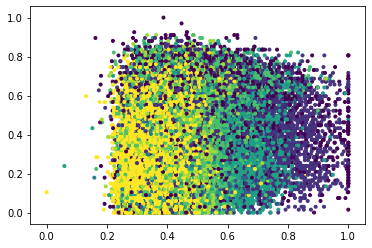

In [115]:
plt.scatter(data['BMI'][:],data['Ins_Age'][:],c=y_data,marker='.')

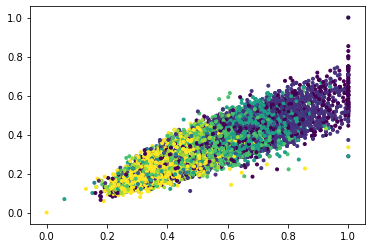

In [129]:
plt.scatter(data['BMI'][:],data['Wt'][:],c=y_data,marker='.')

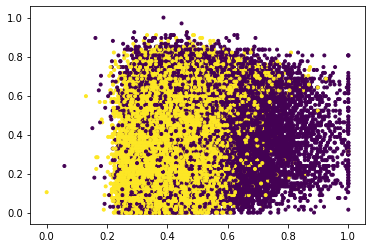

In [126]:
y_data2 = []
for i in y_data:
  if(i>5):
    y_data2.append(1)
  else:
    y_data2.append(0)
plt.scatter(data['BMI'][:],data['Ins_Age'][:],c=y_data2,marker='.')

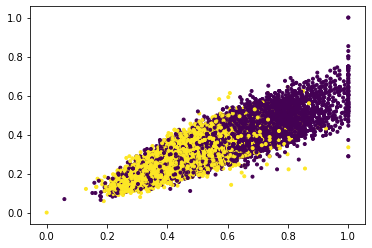

In [127]:
plt.scatter(data['BMI'][:],data['Wt'][:],c=y_data2,marker='.')

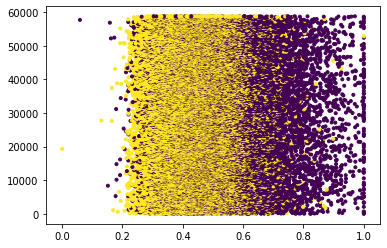

In [128]:
plt.scatter(data['BMI'][:],data.index,c=y_data2,marker='.')